In [28]:
from mewpy.io import Reader, Engines, read_model, read_json
from mewpy.germ.analysis import get_real_initial_state, ifva, SRFBA, FBA
import pandas as pd
import os
import re

In [96]:
trn_fname = "..\\data\\pypath\\grouped_sirt1_trn_manually_curated.csv"
trn_reader = Reader(Engines.BooleanRegulatoryCSV,
                        trn_fname, sep=',', id_col=0, rule_col=1, header=0)

In [97]:
fluxes = pd.read_excel("..\\data\\nutrition\\NewDiets.xlsx").set_index("Unnamed: 0").to_dict()["Basic medium"]

In [98]:
dataset = '..\\data\\GTEx\\RNASeq_log2_normalized.parquet'

In [99]:
gtex_df = pd.read_parquet(dataset)

In [100]:
gtex_df_normalized = gtex_df.div(gtex_df.max())

In [101]:
irreversible = pd.read_excel("..\\data\\nutrition\\irreversible.xlsx", header = None)[0].to_list()

In [102]:
results_regulatory = {}
results_metabolic = {}
models_dir = "..\\results\\GTEx\\fastcore_models_HAM_medium_sinks_closed_irreversibles_core"
for sbml_fname in os.listdir(models_dir):
    tissue = sbml_fname.split(".")[0].split("Recon3D_")[-1].split("_")[-1]
    print("tissue =",tissue)
    sbml_fname = models_dir+"\\"+sbml_fname
    print("sbml_fname =", sbml_fname)
    recon_reader = Reader(Engines.MetabolicSBML, sbml_fname)
    model = read_model(recon_reader, trn_reader)
    print("#Reactions =",len(model.reactions))
    
    fba_model = FBA(model).build()
    srfba_model = SRFBA(model).build()
    
    sol_metabolic = fba_model.optimize()
    print("Solution metabolic =",sol_metabolic.objective_value)
    results_metabolic[tissue] = sol_metabolic.to_series()

    real_initial_state = get_real_initial_state(model, initial_state={"SIRT1": gtex_df_normalized.loc["SIRT1"][tissue]}, strategy="mean")
    sol = srfba_model.optimize(initial_state = real_initial_state)
    print("Solution regulatory =",sol.objective_value)
    results_regulatory[tissue] = sol.to_series()
    print("------------------------------------")
    print()
    

tissue = Adipose - Subcutaneous
sbml_fname = ..\results\GTEx\fastcore_models_HAM_medium_sinks_closed_irreversibles_core\Recon3D_Adipose - Subcutaneous.xml
#Reactions = 5932
Solution metabolic = 16.88863968762772
Solution regulatory = 6.387933740700994
------------------------------------

tissue = Adipose - Visceral (Omentum)
sbml_fname = ..\results\GTEx\fastcore_models_HAM_medium_sinks_closed_irreversibles_core\Recon3D_Adipose - Visceral (Omentum).xml
#Reactions = 5942
Solution metabolic = 16.88863968762772
Solution regulatory = 6.387933740700994
------------------------------------

tissue = Adrenal Gland
sbml_fname = ..\results\GTEx\fastcore_models_HAM_medium_sinks_closed_irreversibles_core\Recon3D_Adrenal Gland.xml
#Reactions = 5996
Solution metabolic = 16.80834543965132
Solution regulatory = 6.387933740700994
------------------------------------

tissue = Artery - Aorta
sbml_fname = ..\results\GTEx\fastcore_models_HAM_medium_sinks_closed_irreversibles_core\Recon3D_Artery - Aorta.x

#Reactions = 6635
Solution metabolic = 16.88863968762772
Solution regulatory = 6.387933740700992
------------------------------------

tissue = Esophagus - Muscularis
sbml_fname = ..\results\GTEx\fastcore_models_HAM_medium_sinks_closed_irreversibles_core\Recon3D_Esophagus - Muscularis.xml
#Reactions = 5811
Solution metabolic = 16.88863968762772
Solution regulatory = 6.387933740700994
------------------------------------

tissue = Fallopian Tube
sbml_fname = ..\results\GTEx\fastcore_models_HAM_medium_sinks_closed_irreversibles_core\Recon3D_Fallopian Tube.xml
#Reactions = 5869
Solution metabolic = 16.88863968762772
Solution regulatory = 6.387933740700994
------------------------------------

tissue = Heart - Atrial Appendage
sbml_fname = ..\results\GTEx\fastcore_models_HAM_medium_sinks_closed_irreversibles_core\Recon3D_Heart - Atrial Appendage.xml
#Reactions = 6481
Solution metabolic = 16.88863968762772
Solution regulatory = 6.387933740700992
------------------------------------

tissue 

In [103]:
df_regulatory = pd.DataFrame().from_dict(results_regulatory)
df_metabolic = pd.DataFrame().from_dict(results_metabolic)
remove_targets = []
for idx in df_regulatory.index.to_list():
    if idx == "SIRT1":
        continue
    if model.get(idx) and not 'reaction' in model.get(idx).types:
        remove_targets.append(idx)

#df_regulatory = df_regulatory.loc[~df_regulatory.index.isin(model.targets.keys())]
df_regulatory = df_regulatory.loc[~df_regulatory.index.isin(remove_targets)]

In [104]:
# Removing the column 'Brain - Caudate (basal ganglia)'
#df_regulatory = df_regulatory.drop(columns=['Brain - Caudate (basal ganglia)'])
#df_metabolic = df_metabolic.drop(columns=['Brain - Caudate (basal ganglia)'])

# Converting all NaN values to 0.0
df_regulatory = df_regulatory.fillna(0.0)
df_metabolic = df_metabolic.fillna(0.0)

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
#df_regulatory.to_excel(f"..\\results\\GTEx\\data\\NEW_tissues_regulatory_srFBA_raw_NewDiets.xlsx")
#df_metabolic.to_excel(f"..\\results\\GTEx\\data\\NEW_tissues_metabolic_FBA_raw_NewDiets.xlsx")

In [68]:
df_regulatory = pd.read_excel(f"..\\results\\GTEx\\data\\tissues_regulatory_srFBA_raw_NewDiets.xlsx").set_index("Unnamed: 0")
df_metabolic = pd.read_excel(f"..\\results\\GTEx\\data\\tissues_metabolic_FBA_raw_NewDiets.xlsx").set_index("Unnamed: 0")



In [69]:
df_regulatory_normalized = df_regulatory.apply(lambda x: x / np.max(np.abs(x)), axis=1) #Normalization
df_metabolic_normalized = df_metabolic.apply(lambda x: x / np.max(np.abs(x)), axis=1) #Normalization

In [70]:
#df_regulatory_normalized.to_excel(f"..\\results\\GTEx\\data\\normalized_tissues_regulatory_srFBA_raw_NewDiets.xlsx")
#df_metabolic_normalized.to_excel(f"..\\results\\GTEx\\data\\normalized_tissues_metabolic_FBA_raw_NewDiets.xlsx")

In [71]:
#df_regulatory_normalized = pd.read_excel(f"..\\results\\GTEx\\data\\normalized_tissues_regulatory_srFBA_raw_NewDiets.xlsx").set_index("Unnamed: 0")
#df_metabolic_normalized = pd.read_excel(f"..\\results\\GTEx\\data\\normalized_tissues_metabolic_FBA_raw_NewDiets.xlsx").set_index("Unnamed: 0")


In [72]:
df_regulatory_normalized = df_regulatory_normalized.loc[:, df_regulatory_normalized.nunique() > 1]
df_metabolic_normalized = df_metabolic_normalized.loc[:, df_metabolic_normalized.nunique() > 1]

non_zero_regulatory_df = df_regulatory_normalized.loc[(df_regulatory_normalized != 0).all(axis=1)]
non_zero_metabolic_df = df_metabolic_normalized.loc[(df_metabolic_normalized != 0).all(axis=1)]

In [118]:
df_normalized_metabolic = non_zero_metabolic_df
df_normalized_regulatory = non_zero_regulatory_df

def filterDF(df_normalized):
    
    
    df_normalized = df_normalized.loc[:, df_normalized.nunique() > 1]
    non_zero_flux_df = df_normalized.loc[(df_normalized != 0).all(axis=1)]
    non_zero_flux_df_T = non_zero_flux_df.T
    #filtered_reactions = [rxn for rxn in df_normalized.columns if rxn in rxn2subsystem.keys() and not rxn.startswith("EX_") and not re.search("Transport, extracellular", rxn2subsystem[rxn])]
    #df_normalized = df_normalized[filtered_reactions]

    # Calculate the variance for each reaction across all conditions before normalization
    reaction_variance = non_zero_flux_df_T.std(axis=0).sort_values(ascending=False)

    # Apply the top percentage filter (e.g., top 10%)
    top_percentage = 0.15  # Change this to the desired percentage
    threshold = reaction_variance.quantile(1 - top_percentage)
    variance_filter = reaction_variance[reaction_variance >= threshold].index
    df_filtered = non_zero_flux_df_T[variance_filter].T
    return df_filtered


df_fba = filterDF(df_normalized_metabolic)
df_srfba = filterDF(df_normalized_regulatory)
df_srfba = df_srfba.drop(columns=['Brain - Nucleus accumbens (basal ganglia)'])

In [49]:
#df_filtered = df_filtered.drop(columns=['Cervix - Ectocervix', 'Cervix - Endocervix', 'Adrenal Gland'])
#df_filtered = df_filtered.drop(columns=['Brain - Nucleus accumbens (basal ganglia)'])

In [50]:
from cobra.io import read_sbml_model
import cobra
config = cobra.Configuration()
config.solver = 'cplex'
sbml_fname = "..\\data\\models\\sirt1_recon3d\\Recon3D_SIRT1_generic_gpr_fix.xml"
cobraModel = read_sbml_model(sbml_fname)

In [51]:
rxn2subsystem = {}
for r in cobraModel.reactions:
    r_id = r.id
    rxn2subsystem[r_id] = cobraModel.reactions.get_by_id(r_id).subsystem

In [54]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib.patches import Patch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [122]:
def createHeatmap(df_filtered):
    # Create a colormap for the subsystems
    subsystems = df_filtered.index.map(rxn2subsystem).unique()
    colormap = sns.color_palette("tab20", len(subsystems))
    subsystem_colors = {subsys: color for subsys, color in zip(subsystems, colormap)}
    
    # Map the colors to the reactions
    row_colors = df_filtered.index.map(lambda rxn: subsystem_colors[rxn2subsystem[rxn]])

    # Create a clustered heatmap without displaying the numbers
    g = sns.clustermap(df_filtered, cmap="viridis", annot=False, figsize=(20, 20), vmin=-1, vmax=1)

    # Rotate x labels
    plt.setp(g.ax_heatmap.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", fontsize=16)

    # Manually color the y-axis labels
    for tick_label in g.ax_heatmap.yaxis.get_majorticklabels():
        rxn_name = tick_label.get_text()
        tick_label.set_color(subsystem_colors[rxn2subsystem[rxn_name]])
        tick_label.set_weight("bold")  # Make the text bold
        tick_label.set_fontsize(16)  # Adjust font size

    g.cax.set_position([0.1, .82, .03, .2])  # (left, bottom, width, height)
    # Create a legend for the subsystems
    handles = [Patch(facecolor=subsystem_colors[subsys], label=subsys) for subsys in subsystems]
    plt.legend(handles=handles, title="Subsystems", bbox_to_anchor=(26.5, 0.95), loc='upper left', fontsize=14, title_fontsize=14)

    #plt.title("Top 15% reactions: Normalized Fluxes Heatmap for Different Diets and SIRT1 Expression Values")
    plt.show()

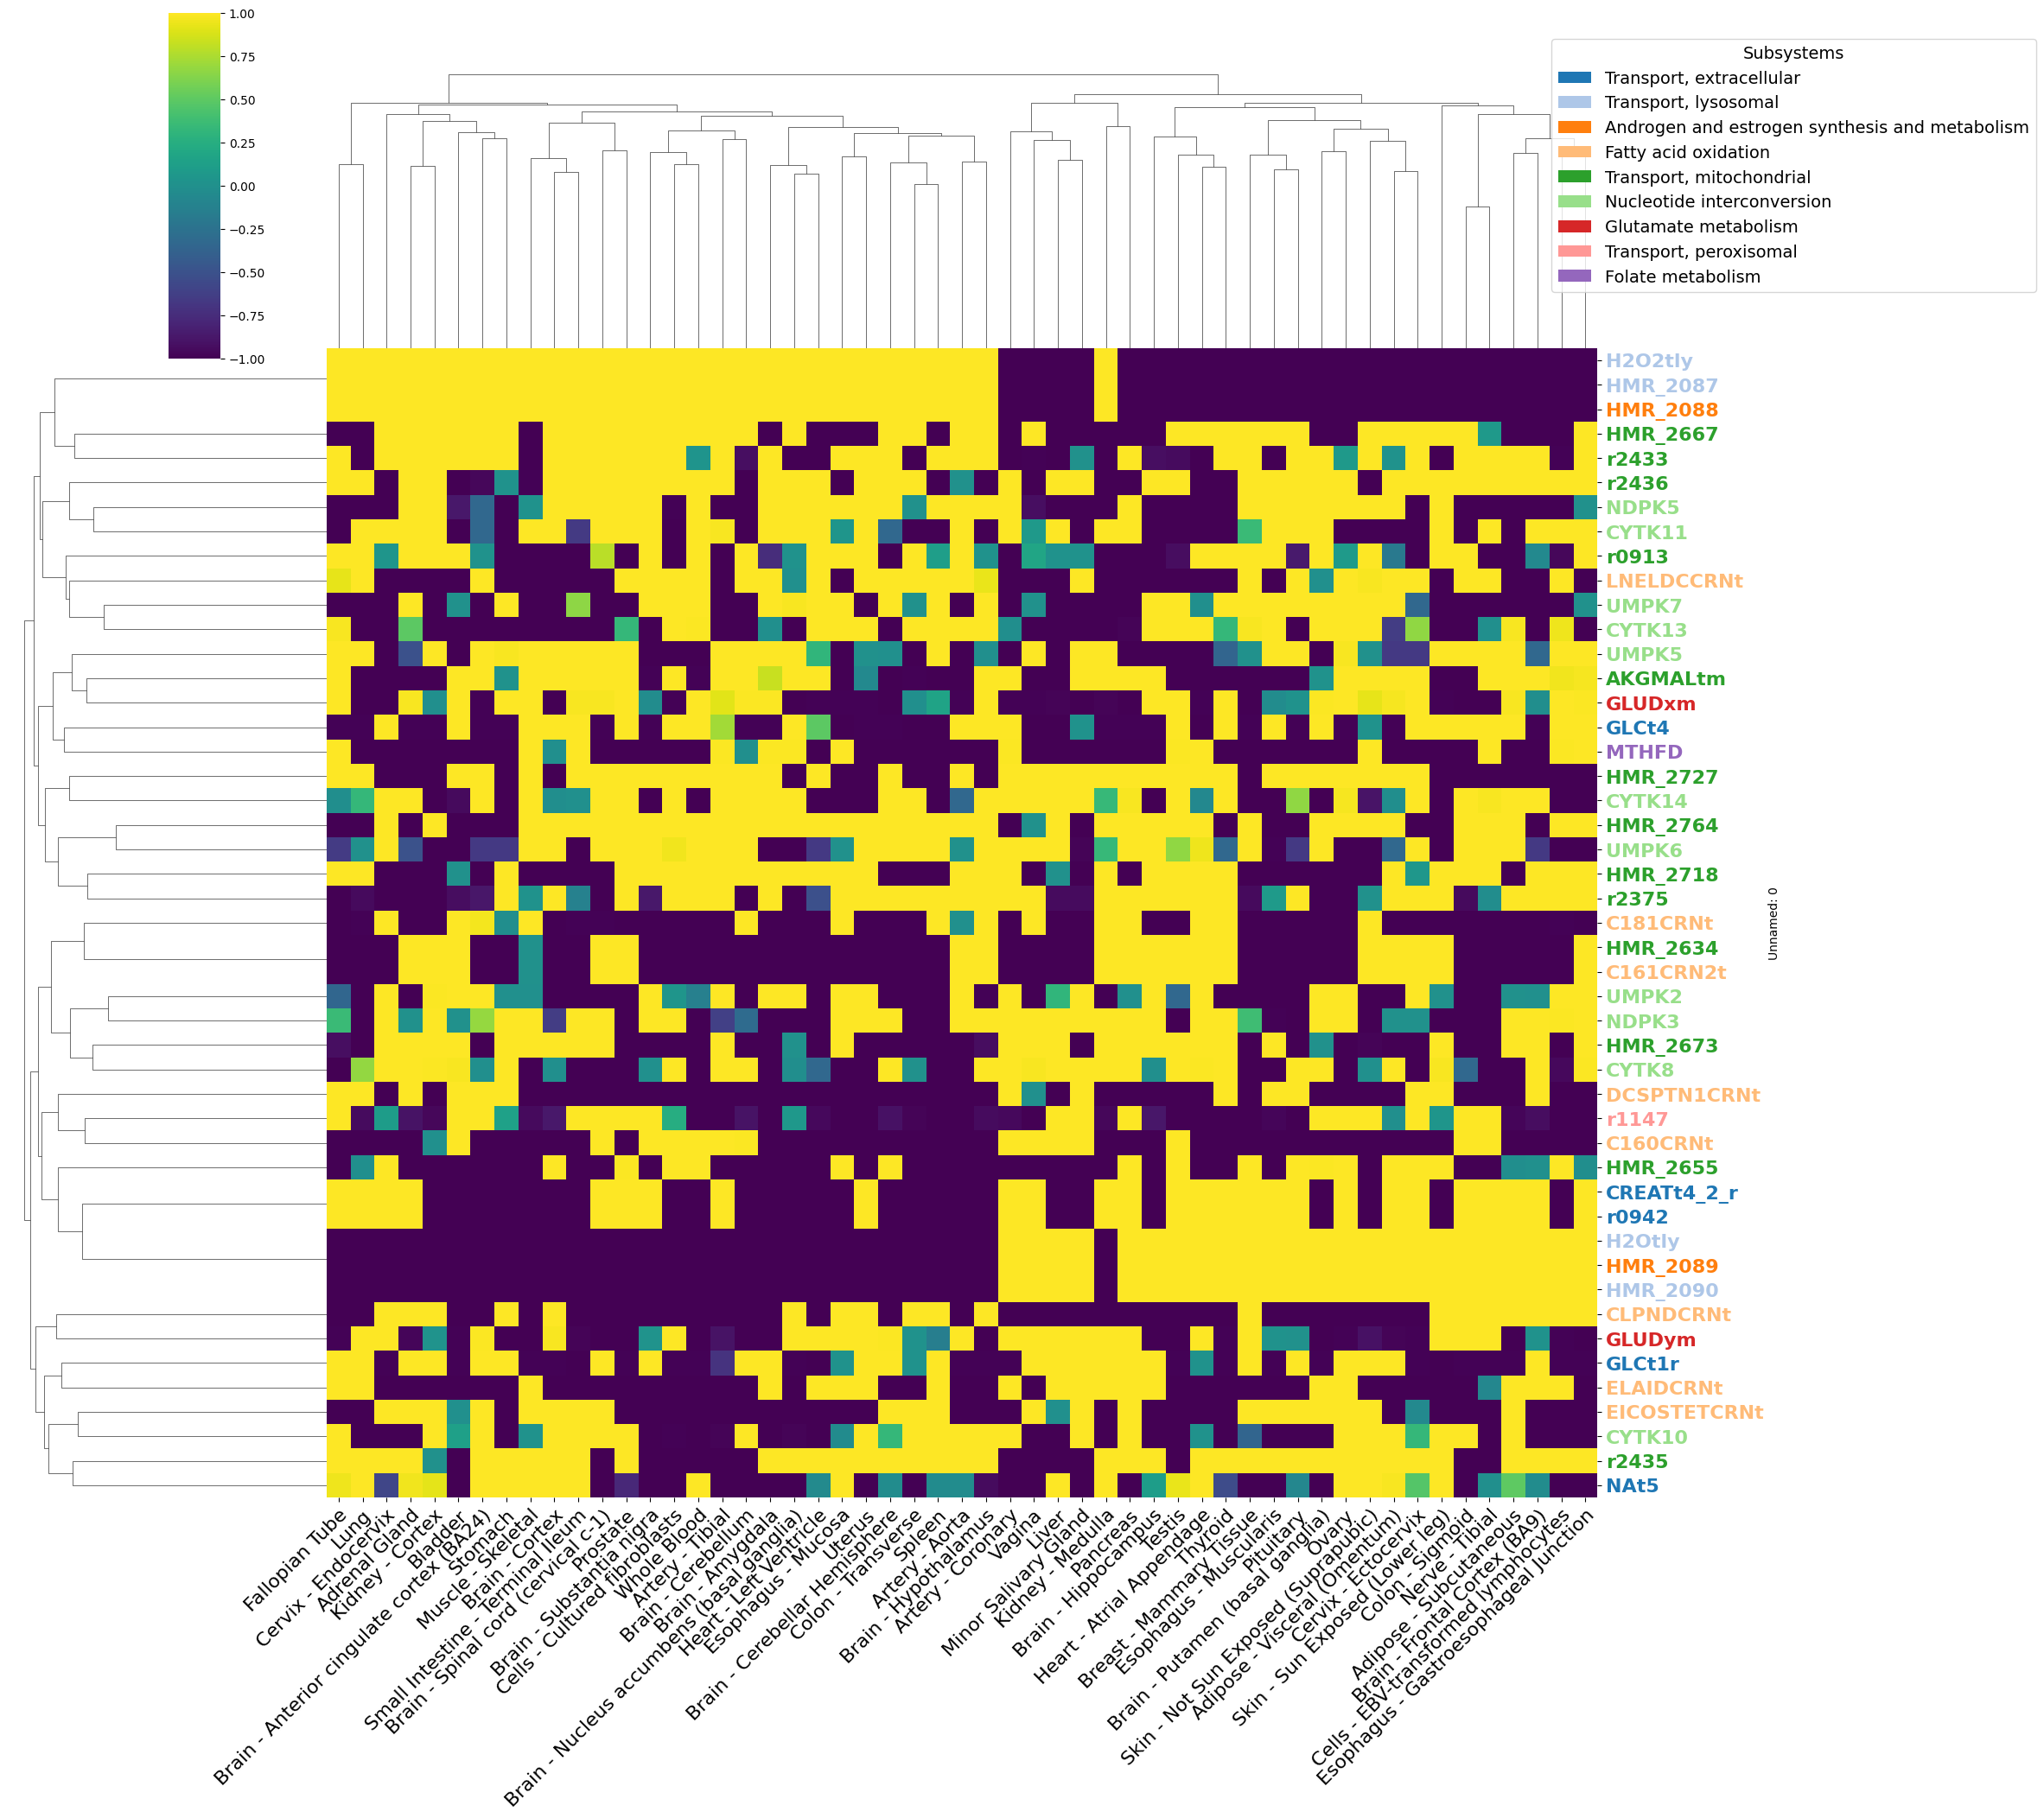

In [123]:
createHeatmap(df_fba)

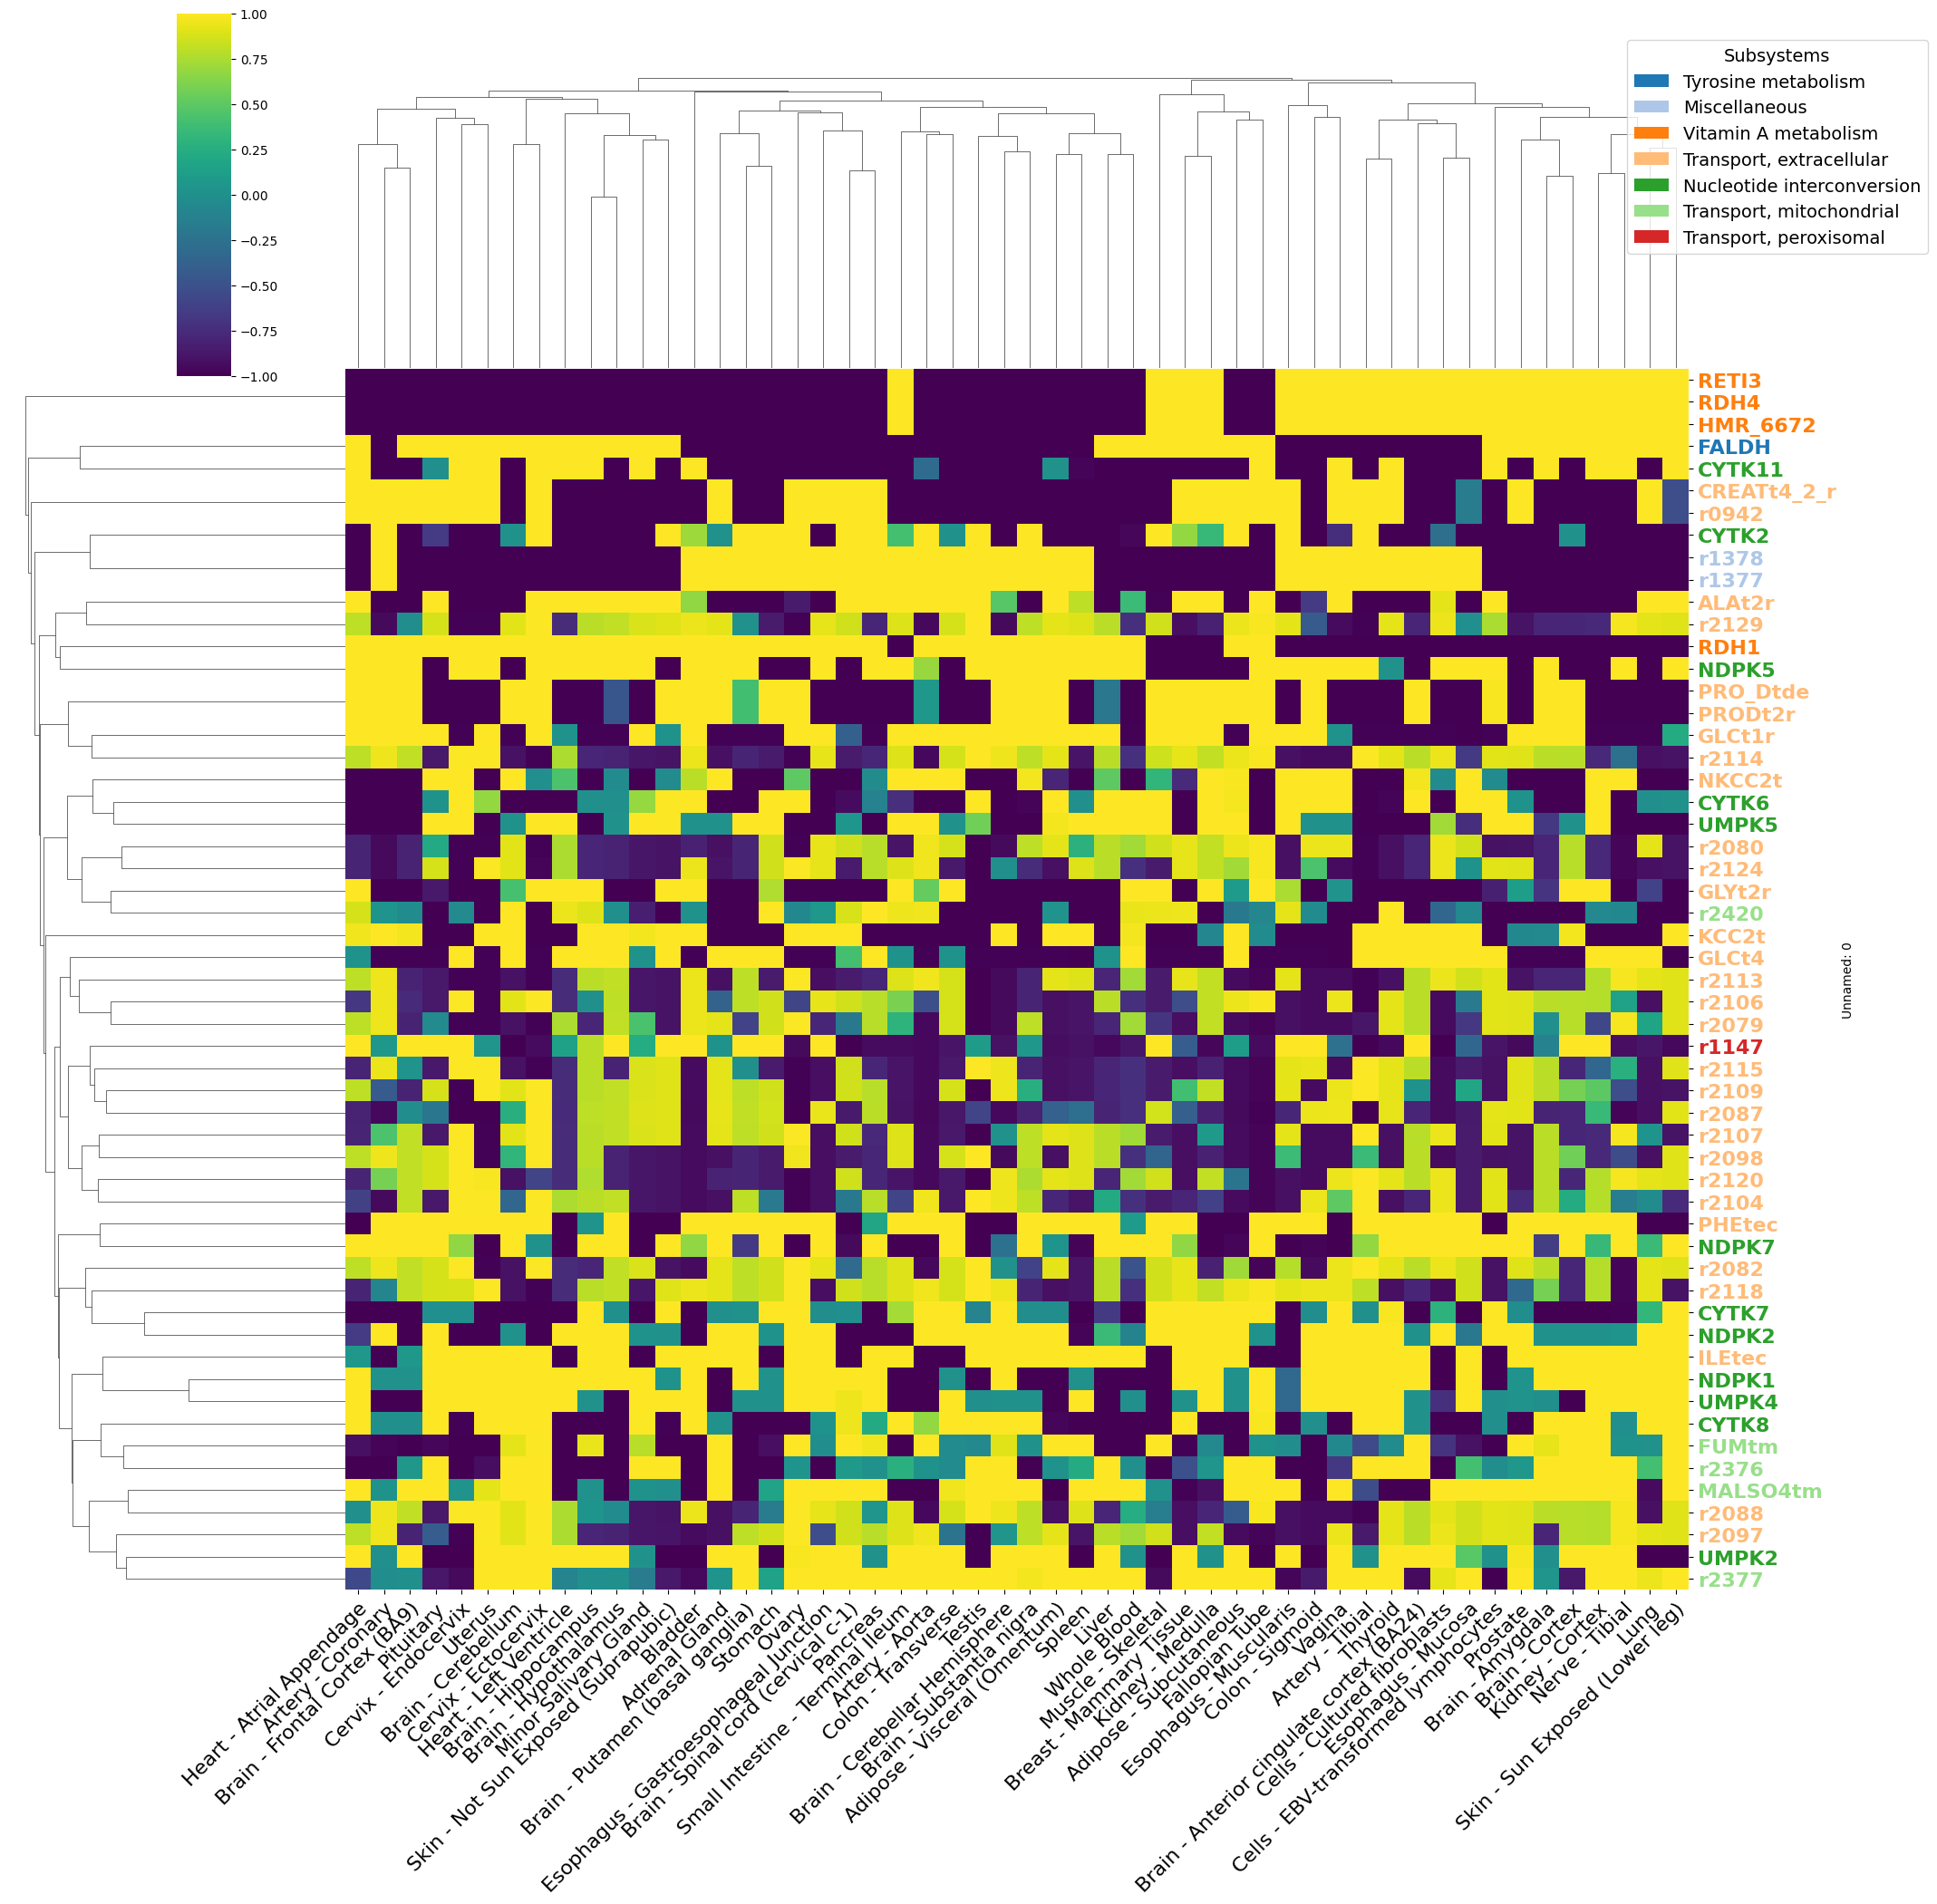

In [124]:
createHeatmap(df_srfba)

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from adjustText import adjust_text

# Assume the DataFrame `df_filtered` is already prepared as described previously
def createPCAPlot(df_filtered, fba_type="unknown"):
    # Standardize the data
    scaler = StandardScaler()
    df_standardized = scaler.fit_transform(df_filtered.T)

    # Perform PCA
    pca = PCA(n_components=2)  # Reduce to 2 components for visualization
    principal_components = pca.fit_transform(df_standardized)

    # Run K-means clustering
    n_clusters = 5
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)  # Change n_clusters to desired number of clusters
    clusters = kmeans.fit_predict(principal_components)

    # Create a DataFrame for the principal components and clusters
    pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
    pca_df['Label'] = [f"{diet}" for diet in df_filtered.T.index]
    pca_df['Cluster'] = clusters

    # Plot PCA with K-means clusters
    plt.figure(figsize=(14, 10))
    scatter_plot = sns.scatterplot(x='PC1', y='PC2', data=pca_df, hue='Cluster', palette='tab10', s=200)

    # Annotate each point with its label
    texts = []
    for i in range(pca_df.shape[0]):
        texts.append(plt.text(x=pca_df.PC1[i] + 0.02, y=pca_df.PC2[i] + 0.02, s=pca_df.Label[i],
                              fontdict=dict(color='black', size=12), bbox=dict(facecolor='white', alpha=0.5, edgecolor='none')))

    adjust_text(texts, only_move={'points':'y', 'texts':'y'}, arrowprops=dict(arrowstyle='-', color='grey', alpha=0.5))

    plt.title(f'PCA of {fba_type} with K-means Clustering', fontsize=20)
    plt.xlabel('Principal Component 1', fontsize=16)
    plt.ylabel('Principal Component 2', fontsize=16)
    plt.legend().set_visible(False)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

# Example usage
# createPCAPlot(df_filtered, fba_type="srFBA")


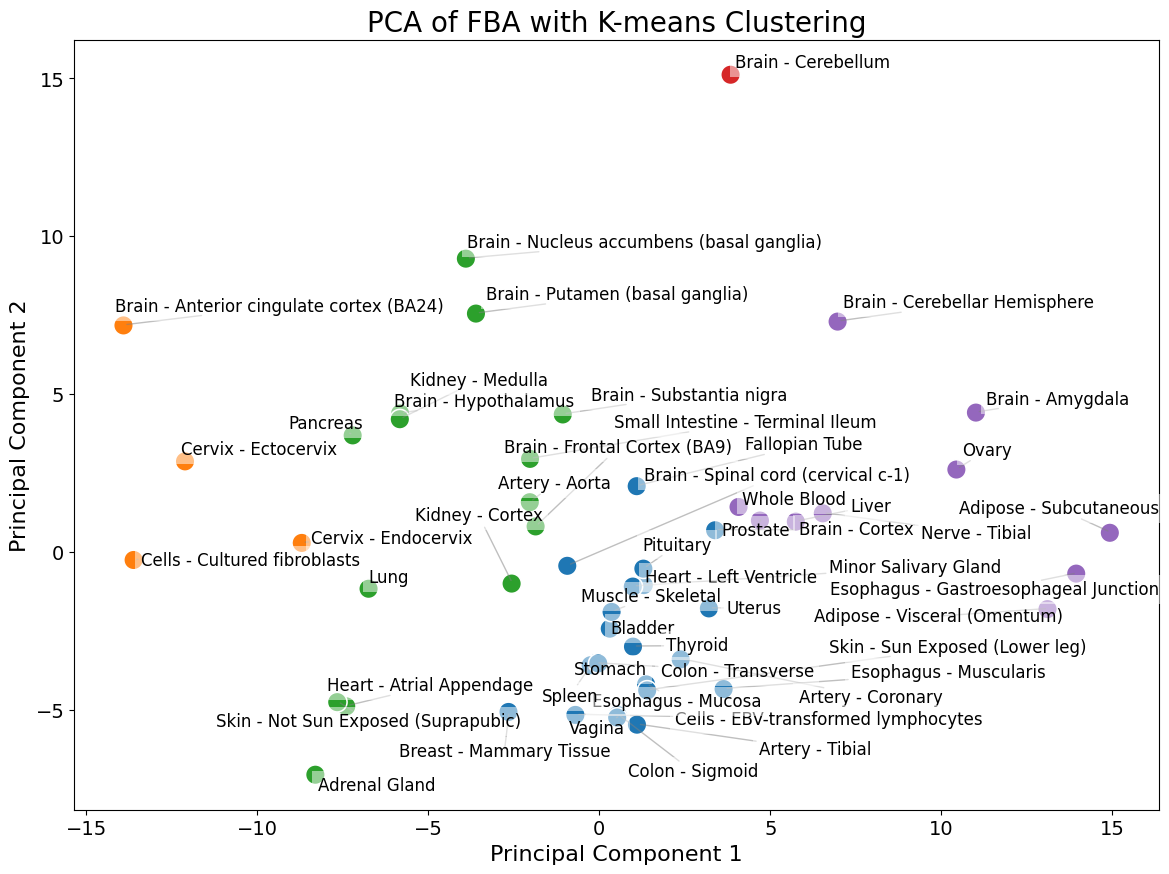

In [86]:
createPCAPlot(df_fba.drop(columns=['Testis','Brain - Hippocampus']),fba_type="FBA")

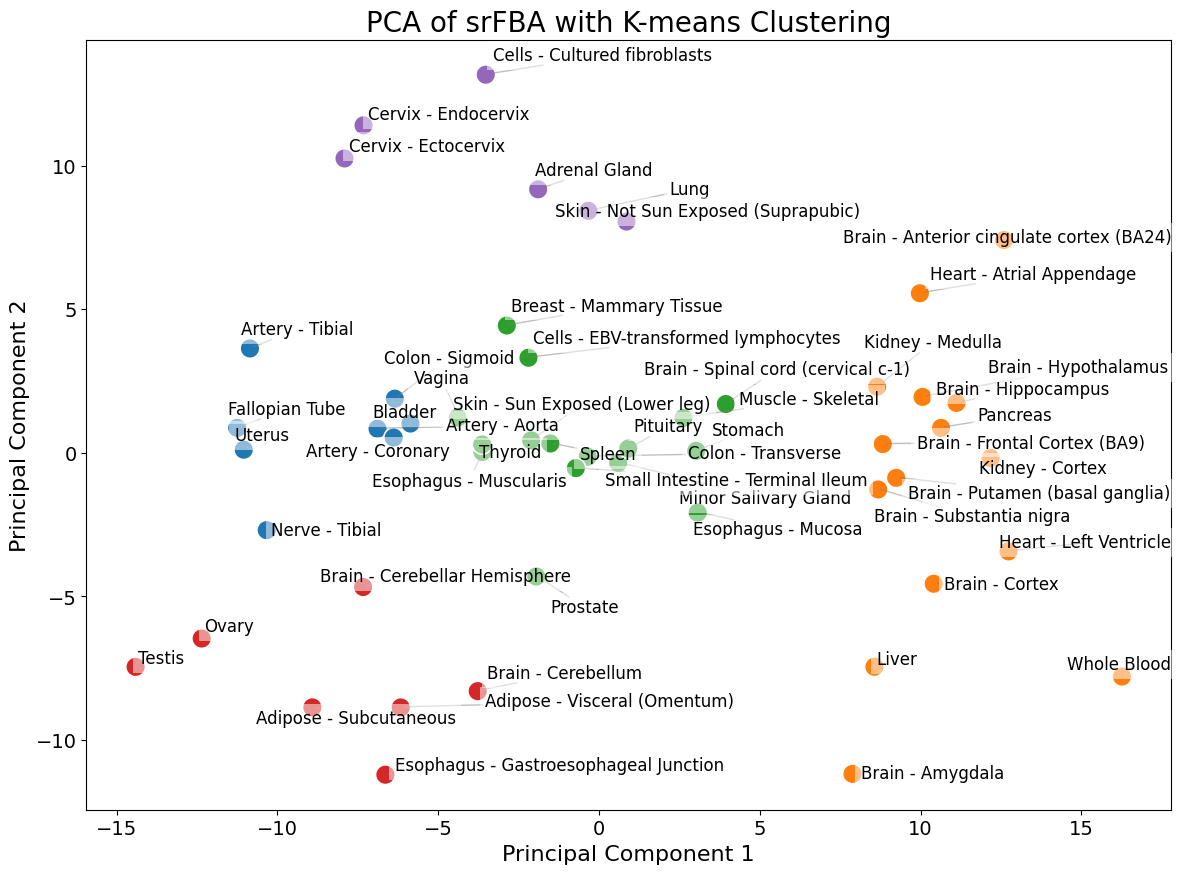

In [87]:
createPCAPlot(df_srfba.drop(columns=['Brain - Nucleus accumbens (basal ganglia)']),fba_type="srFBA")

In [133]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import plotly.express as px

# Assume df_filtered is already prepared as described previously
def createInteractivePCA(df_filtered, save_figure = False, fba_type = "unknown"):
    # Standardize the data
    scaler = StandardScaler()
    df_standardized = scaler.fit_transform(df_filtered.T)

    # Perform PCA
    pca = PCA(n_components=2)  # Reduce to 2 components for visualization
    principal_components = pca.fit_transform(df_standardized)

    # Run K-means clustering
    n_clusters = 5  # Change n_clusters to desired number of clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    clusters = kmeans.fit_predict(principal_components)

    # Create a DataFrame for the principal components and clusters
    pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
    pca_df['Label'] = df_filtered.T.index
    pca_df['Cluster'] = clusters

    # Create the interactive scatter plot with Plotly
    fig = px.scatter(
        pca_df, x='PC1', y='PC2', color='Cluster', hover_name='Label',
        title=f'Tissue-specific {fba_type} PCA', labels={'Cluster': 'Cluster'}
    )

    # Update the layout to improve the look and increase marker size
    fig.update_traces(marker=dict(size=12))  # Increase the size of the dots

    # Update the layout to improve the look
    fig.update_layout(
        legend_title_text='Cluster',
        title_x=0.5,  # Center the title
        legend=dict(title='Clusters', itemsizing='constant'),
        margin=dict(l=0, r=0, b=0, t=40),
    )

    # Show the interactive plot
    fig.show()

    # Save the interactive plot as an HTML file
    if save_figure:
        fig.write_html(f"..\\results\\GTEx\\data\\Figures\\interactive_2D_tissue_pca_{fba_type}.html")


In [138]:
createInteractivePCA(df_fba, fba_type = "FBA")

In [137]:
createInteractivePCA(df_srfba.drop(columns=['Liver']), fba_type = "srFBA")

In [90]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import plotly.express as px
import plotly.graph_objects as go

In [91]:
import plotly.io as pio
pio.renderers.default = 'notebook'

In [106]:
df_filtered = df_srfba.drop(columns=['Liver'])

# Assume df_normalized is already prepared as described previously
df_normalized = df_filtered.T
# Standardize the data
scaler = StandardScaler()
df_standardized = scaler.fit_transform(df_normalized)

# Perform PCA
pca = PCA(n_components=3)  # Reduce to 3 components for visualization
principal_components = pca.fit_transform(df_standardized)

# Run K-means clustering
kmeans = KMeans(n_clusters=5, random_state=0)  # Change n_clusters to desired number of clusters
clusters = kmeans.fit_predict(principal_components)


# Create a DataFrame for the principal components and clusters
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])
pca_df['Label'] = df_normalized.index
pca_df['Cluster'] = clusters

# Create the scatter plot
fig = px.scatter_3d(
    pca_df, x='PC1', y='PC2', z='PC3',
    color='Cluster', hover_name='Label',
    title='Tissue-specific 3D PCA'
)

# Update the layout to show legend and improve the look
fig.update_layout(
    legend=dict(title="Clusters", itemsizing='constant'),
    margin=dict(l=0, r=0, b=0, t=40),
)

#fig.write_html(f"..\\results\\GTEx\\data\\Figures\\interactive_3D_tissue_pca_{fba_type}.html")
# Show the interactive plot
fig.show()

In [155]:
from cobra.io import read_sbml_model
import cobra
config = cobra.Configuration()
config.solver = 'cplex'
sbml_fname = "..\\data\\models\\sirt1_recon3d\\Recon3D_SIRT1_generic_gpr_fix.xml"
cobraModel = read_sbml_model(sbml_fname)

rxn2subsystem = {}
for r in cobraModel.reactions:
    r_id = r.id
    rxn2subsystem[r_id] = cobraModel.reactions.get_by_id(r_id).subsystem

In [107]:
# Extract the principal components (loadings)
principal_components_loadings = pca.components_

# Create a DataFrame for the loadings
loadings_df = pd.DataFrame(principal_components_loadings.T, 
                           columns=['PC1', 'PC2', 'PC3'], 
                           index=df_normalized.columns)

# Display the loadings for the first two principal components
#print(loadings_df)

# Optionally, find the top contributing features for each principal component
top_contributors_pc1 = loadings_df['PC1'].abs().sort_values(ascending=False).head(10)
top_contributors_pc2 = loadings_df['PC2'].abs().sort_values(ascending=False).head(10)
top_contributors_pc3 = loadings_df['PC3'].abs().sort_values(ascending=False).head(10)

In [108]:
print("Top contributors to PC1\n")
for k, v in top_contributors_pc1.items():
    print(k,v, rxn2subsystem[k])
print()
print("Top contributors to PC2\n")
for k, v in top_contributors_pc2.items():
    print(k,v, rxn2subsystem[k])
print()
print("Top contributors to PC3\n")
for k, v in top_contributors_pc3.items():
    print(k,v, rxn2subsystem[k])

Top contributors to PC1

SMS 0.12576130251645234 Sphingolipid metabolism
XOLEST2te 0.1239093957914099 Transport, extracellular
r0483 0.12387883989465406 Pyrimidine catabolism
PGMT 0.12387588761724852 Glycolysis/gluconeogenesis
UGCG 0.12387588761724586 Sphingolipid metabolism
UDPGLCter 0.12387588761724586 Transport, endoplasmic reticular
CERT1rt 0.12387588761724586 Transport, endoplasmic reticular
GALK 0.1238758876172452 Galactose metabolism
SPHMDAc 0.12387588761724519 Sphingolipid metabolism
ME2 0.12387588761724519 Pyruvate metabolism

Top contributors to PC2

DATPtn 0.16679886648942358 Transport, nuclear
DHORTS 0.1667988664894171 Pyrimidine synthesis
ASPCTr 0.1667988664894171 Pyrimidine synthesis
OMPDC 0.1667988664894171 Pyrimidine synthesis
CBPS 0.1667988664894171 Pyrimidine synthesis
ORPT 0.1667988664894171 Pyrimidine synthesis
DHORD9 0.1667988664894171 Pyrimidine synthesis
DSAT 0.16679886648939937 Sphingolipid metabolism
CLS_hs 0.16679886648939873 Glycerophospholipid metabolism
bio

In [109]:
with open(f"..\\results\\GTEx\\data\\Figures\\pca_tisue_srFBA.csv", "w+") as fopen:
    fopen.write("Top contributors to PC1\n")
    for k, v in top_contributors_pc1.items():
        print(k,v, rxn2subsystem[k])
        fopen.write(f"{k};{v};{rxn2subsystem[k]}\n")

    fopen.write("Top contributors to PC2\n")
    for k, v in top_contributors_pc2.items():
        print(k,v, rxn2subsystem[k])
        fopen.write(f"{k};{v};{rxn2subsystem[k]}\n")

    fopen.write("Top contributors to PC3\n")
    for k, v in top_contributors_pc3.items():
        print(k,v, rxn2subsystem[k])
        fopen.write(f"{k};{v};{rxn2subsystem[k]}\n")

SMS 0.12576130251645234 Sphingolipid metabolism
XOLEST2te 0.1239093957914099 Transport, extracellular
r0483 0.12387883989465406 Pyrimidine catabolism
PGMT 0.12387588761724852 Glycolysis/gluconeogenesis
UGCG 0.12387588761724586 Sphingolipid metabolism
UDPGLCter 0.12387588761724586 Transport, endoplasmic reticular
CERT1rt 0.12387588761724586 Transport, endoplasmic reticular
GALK 0.1238758876172452 Galactose metabolism
SPHMDAc 0.12387588761724519 Sphingolipid metabolism
ME2 0.12387588761724519 Pyruvate metabolism
DATPtn 0.16679886648942358 Transport, nuclear
DHORTS 0.1667988664894171 Pyrimidine synthesis
ASPCTr 0.1667988664894171 Pyrimidine synthesis
OMPDC 0.1667988664894171 Pyrimidine synthesis
CBPS 0.1667988664894171 Pyrimidine synthesis
ORPT 0.1667988664894171 Pyrimidine synthesis
DHORD9 0.1667988664894171 Pyrimidine synthesis
DSAT 0.16679886648939937 Sphingolipid metabolism
CLS_hs 0.16679886648939873 Glycerophospholipid metabolism
biomass_reaction 0.1667988664893987 Exchange/demand re

In [157]:
top_contributors_pc1

STCRNte        0.117454
SMPD4          0.117454
HDCECRNte      0.117454
ACRNte         0.117454
HC02149td      0.117454
HMR_2760       0.117454
STCRNtr        0.117454
ODECRNte       0.117454
ACRNtr         0.117454
LNELDCCRNte    0.117454
Name: PC1, dtype: float64

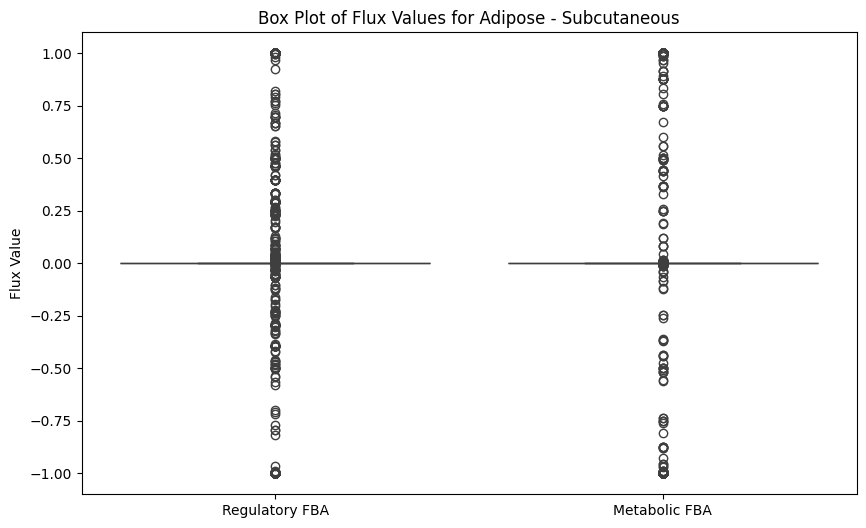

In [181]:
import seaborn as sns

# Combine data for box plot
combined_df = pd.DataFrame({
    'Regulatory FBA': df_regulatory_normalized[condition],
    'Metabolic FBA': df_metabolic_normalized[condition]
})

plt.figure(figsize=(10, 6))
sns.boxplot(data=combined_df)
plt.title(f'Box Plot of Flux Values for {condition}')
plt.ylabel('Flux Value')
plt.show()

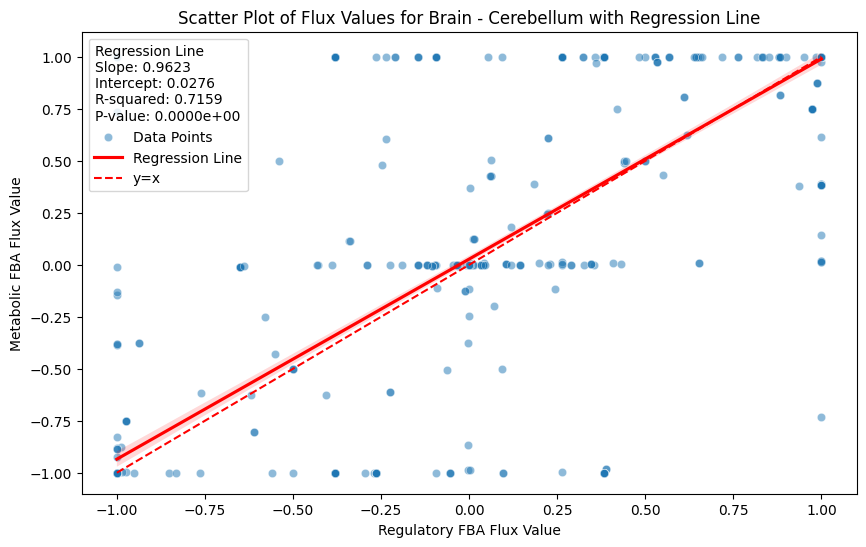

In [200]:
from scipy.stats import linregress

# Choose a condition to plot
condition = 'Brain - Cerebellum'

# Combine data for scatter plot
combined_df = pd.DataFrame({
    'Regulatory FBA': df_regulatory_normalized[condition],
    'Metabolic FBA': df_metabolic_normalized[condition]
})

# Filter out pairs where both flux values are zero using AND condition
filtered_df = combined_df[(combined_df['Regulatory FBA'] != 0) & (combined_df['Metabolic FBA'] != 0)]

# Calculate regression parameters
slope, intercept, r_value, p_value, std_err = linregress(filtered_df['Regulatory FBA'], filtered_df['Metabolic FBA'])

# Create scatter plot with regression line
plt.figure(figsize=(10, 6))
sns.scatterplot(data=filtered_df, x='Regulatory FBA', y='Metabolic FBA', alpha=0.5, label='Data Points')
sns.regplot(data=filtered_df, x='Regulatory FBA', y='Metabolic FBA', scatter=False, color='red', label='Regression Line')

# Add regression parameters and p-value to the legend
plt.plot([-1, 1], [-1, 1], 'r--', label='y=x')  # Diagonal line for reference
plt.legend(title=f'Regression Line\nSlope: {slope:.4f}\nIntercept: {intercept:.4f}\nR-squared: {r_value**2:.4f}\nP-value: {p_value:.4e}', loc='upper left')

plt.title(f'Scatter Plot of Flux Values for {condition} with Regression Line')
plt.xlabel('Regulatory FBA Flux Value')
plt.ylabel('Metabolic FBA Flux Value')
plt.show()

In [111]:
df_normalized_metabolic = non_zero_metabolic_df
df_normalized_regulatory = non_zero_regulatory_df

def filterDF(df_normalized):
    df_normalized = df_normalized.loc[:, df_normalized.nunique() > 1]
    non_zero_flux_df = df_normalized.loc[(df_normalized != 0).all(axis=1)]
    non_zero_flux_df_T = non_zero_flux_df.T

    # Calculate the variance for each reaction across all conditions before normalization
    reaction_variance = non_zero_flux_df_T.std(axis=0).sort_values(ascending=False)

    # Apply the top percentage filter (e.g., top 10%)
    top_percentage = 0.90  # Change this to the desired percentage
    threshold = reaction_variance.quantile(1 - top_percentage)
    variance_filter = reaction_variance[reaction_variance >= threshold].index
    df_filtered = non_zero_flux_df_T[variance_filter].T
    return df_filtered


df_fba = filterDF(df_normalized_metabolic)
df_srfba = filterDF(df_normalized_regulatory)

In [139]:
# Find common reactions
common_reactions = df_fba.index.intersection(df_srfba.index)

# Filter dataframes to only include common reactions
df_fba_common = df_fba.loc[common_reactions]
df_srfba_common = df_srfba.loc[common_reactions]

In [140]:
# Example function to standardize data and perform PCA
def calculate_pca_variance(df_normalized):
    # Standardize the data
    scaler = StandardScaler()
    df_standardized = scaler.fit_transform(df_normalized)

    # Perform PCA
    pca = PCA(n_components=3)  # Reduce to 3 components for visualization
    principal_components = pca.fit_transform(df_standardized)

    # Extract explained variance ratios
    explained_variances = pca.explained_variance_ratio_
    return explained_variances

In [141]:
# Function to split the dataframe into a list of tissue-specific dataframes
def split_into_tissue_specific_dfs(df):
    tissue_specific_dfs = []
    for column in df.columns:
        tissue_specific_dfs.append(df[[column]].copy())
    return tissue_specific_dfs

# Split the main dataframes into lists of tissue-specific dataframes
fba_results_list = split_into_tissue_specific_dfs(df_fba_common)
srfba_results_list = split_into_tissue_specific_dfs(df_srfba_common)

In [142]:
# Calculate explained variances for FBA and srFBA
fba_variances = []
srfba_variances = []

for fba_df, srfba_df in zip(fba_results_list, srfba_results_list):
    fba_variances.append(calculate_pca_variance(df_fba)[0])  # Taking the first principal component's variance
    srfba_variances.append(calculate_pca_variance(df_srfba)[0])  # Taking the first principal component's variance

In [143]:
# Create a dataframe to hold the variances
variance_df = pd.DataFrame({
    'FBA': fba_variances,
    'srFBA': srfba_variances
})

# Perform Kruskal-Wallis test
from scipy.stats import kruskal

stat, p_value = kruskal(variance_df['FBA'], variance_df['srFBA'])

print(f"Kruskal-Wallis test statistic: {stat}")
print(f"P-value: {p_value}")

# Interpretation
if p_value < 0.05:
    print("There is a significant difference between FBA and srFBA clustering results.")
else:
    print("There is no significant difference between FBA and srFBA clustering results.")

Kruskal-Wallis test statistic: 82.08921889616465
P-value: 1.300802266750096e-19
There is a significant difference between FBA and srFBA clustering results.


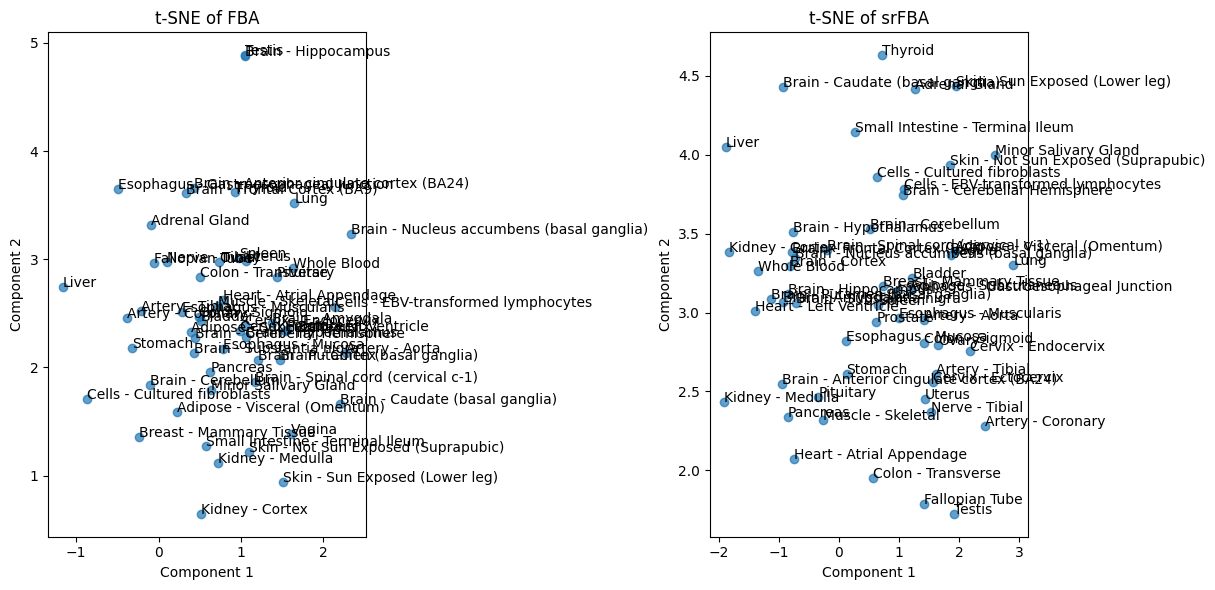

In [145]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

scaler = StandardScaler()
df_fba_standardized = scaler.fit_transform(df_fba.T)
df_srfba_standardized = scaler.fit_transform(df_srfba.T)
    
# Perform t-SNE
tsne_fba = TSNE(n_components=2, random_state=42).fit_transform(df_fba_standardized)
tsne_srfba = TSNE(n_components=2, random_state=42).fit_transform(df_srfba_standardized)

# Extract labels (column names)
labels = df_fba_common.columns.values

# Plot t-SNE results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(tsne_fba[:, 0], tsne_fba[:, 1], alpha=0.7)
for i, label in enumerate(labels):
    plt.annotate(label, (tsne_fba[i, 0], tsne_fba[i, 1]))
plt.title('t-SNE of FBA')
plt.xlabel('Component 1')
plt.ylabel('Component 2')

plt.subplot(1, 2, 2)
plt.scatter(tsne_srfba[:, 0], tsne_srfba[:, 1], alpha=0.7)
for i, label in enumerate(labels):
    plt.annotate(label, (tsne_srfba[i, 0], tsne_srfba[i, 1]))
plt.title('t-SNE of srFBA')
plt.xlabel('Component 1')
plt.ylabel('Component 2')

plt.tight_layout()
plt.show()

In [118]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler

# Assuming df_fba and df_srfba are your dataframes where columns are tissues and index are reactions

def perform_clustering_analysis(df, n_clusters):
    # Standardize the data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(df.T)  # Transpose to have samples as rows
    
    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(data_scaled)
    
    # Calculate Silhouette Score
    silhouette_avg = silhouette_score(data_scaled, cluster_labels)
    
    # Calculate Davies-Bouldin Index
    davies_bouldin_avg = davies_bouldin_score(data_scaled, cluster_labels)
    
    return silhouette_avg, davies_bouldin_avg

# Determine the number of clusters (you might need to adjust this based on your data)
n_clusters = 5

# Perform analysis for FBA
silhouette_fba, davies_bouldin_fba = perform_clustering_analysis(df_fba, n_clusters)
print(f'FBA - Silhouette Score: {silhouette_fba}, Davies-Bouldin Index: {davies_bouldin_fba}')

# Perform analysis for srFBA
silhouette_srfba, davies_bouldin_srfba = perform_clustering_analysis(df_srfba, n_clusters)
print(f'srFBA - Silhouette Score: {silhouette_srfba}, Davies-Bouldin Index: {davies_bouldin_srfba}')

# Compare the results
if silhouette_srfba > silhouette_fba:
    print("srFBA has better-defined clusters based on Silhouette Score.")
else:
    print("FBA has better-defined clusters based on Silhouette Score.")

if davies_bouldin_srfba < davies_bouldin_fba:
    print("srFBA has better-defined clusters based on Davies-Bouldin Index.")
else:
    print("FBA has better-defined clusters based on Davies-Bouldin Index.")


FBA - Silhouette Score: -0.0003791633389073715, Davies-Bouldin Index: 3.161203865617609
srFBA - Silhouette Score: 0.005632229746699565, Davies-Bouldin Index: 3.646841230285672
srFBA has better-defined clusters based on Silhouette Score.
FBA has better-defined clusters based on Davies-Bouldin Index.


C:\Users\romaj\AppData\Local\miniconda3\envs\cobrapy\lib\site-packages\umap\umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

C:\Users\romaj\AppData\Local\miniconda3\envs\cobrapy\lib\site-packages\umap\umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



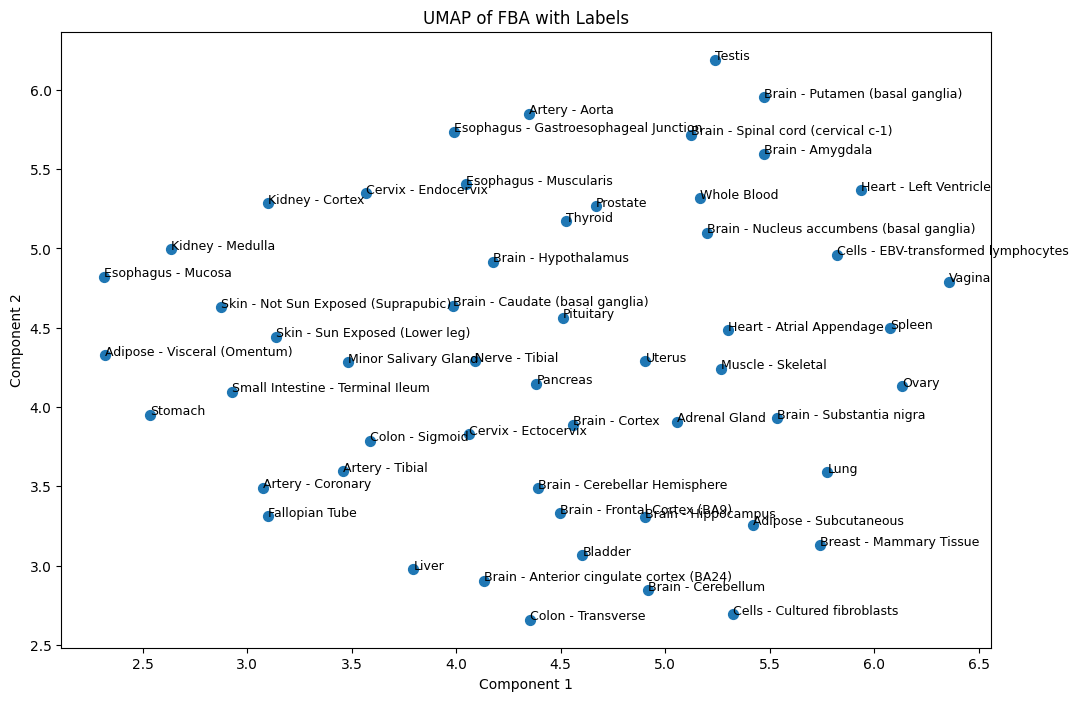

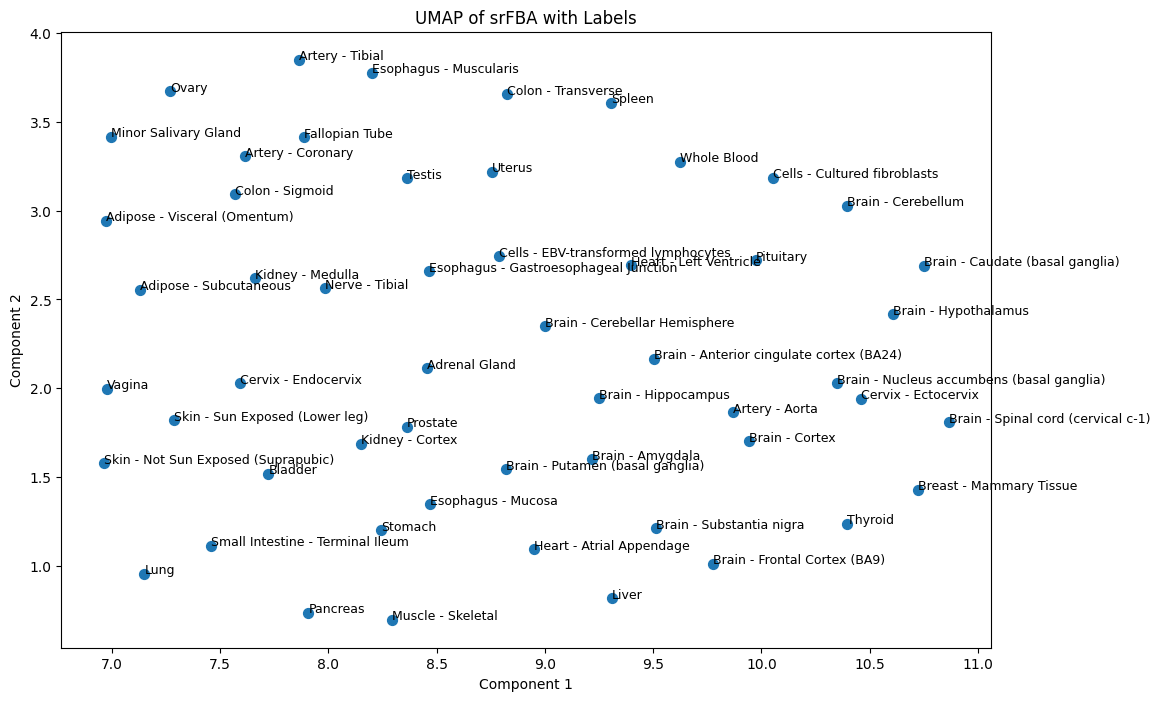

In [119]:
import matplotlib.pyplot as plt
import umap

# Assuming df_fba and df_srfba are your dataframes where columns are tissues and index are reactions
# Assuming you have a list of tissue labels
tissue_labels = df_fba.columns.tolist()  # or df_srfba.columns.tolist()

def apply_umap(df, n_neighbors=15, min_dist=0.1, n_components=2):
    # Transpose the dataframe to have samples as rows
    data = df.T
    
    # Apply UMAP
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components, random_state=42)
    embedding = reducer.fit_transform(data)
    
    return embedding

# Apply UMAP to FBA data
umap_fba = apply_umap(df_fba)

# Apply UMAP to srFBA data
umap_srfba = apply_umap(df_srfba)

# Plot UMAP results with labels
def plot_umap_with_labels(embedding, labels, title):
    plt.figure(figsize=(12, 8))
    plt.scatter(embedding[:, 0], embedding[:, 1], s=50, cmap='Spectral')
    for i, label in enumerate(labels):
        plt.text(embedding[i, 0], embedding[i, 1], label, fontsize=9)
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.show()

# Plot UMAP of FBA with labels
plot_umap_with_labels(umap_fba, tissue_labels, 'UMAP of FBA with Labels')

# Plot UMAP of srFBA with labels
plot_umap_with_labels(umap_srfba, tissue_labels, 'UMAP of srFBA with Labels')


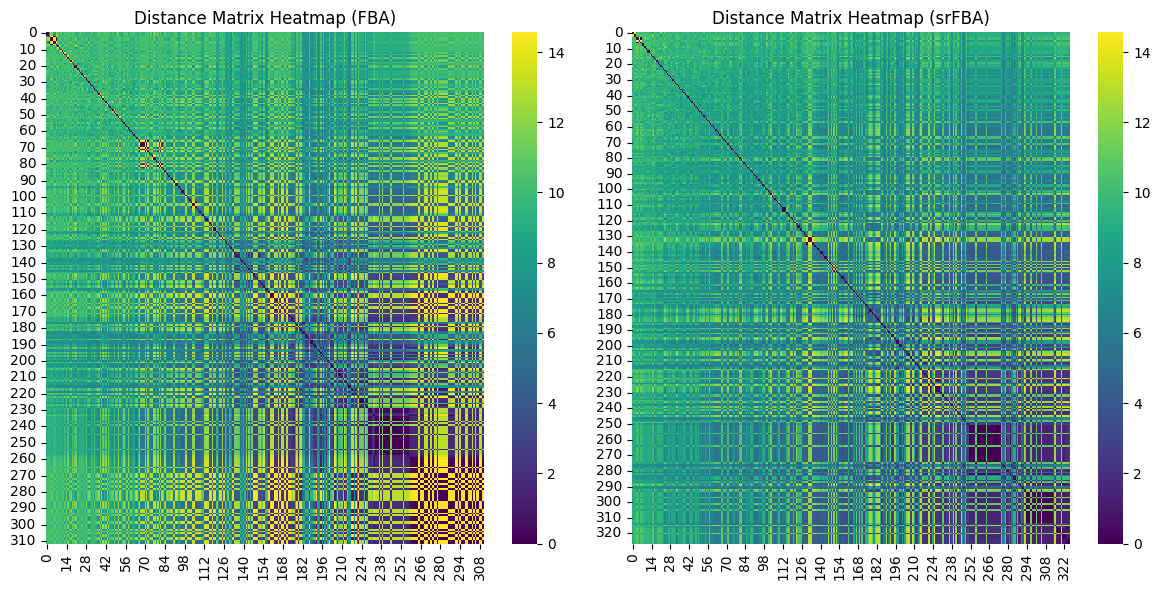

In [82]:
import seaborn as sns
from sklearn.metrics import pairwise_distances

# Compute distance matrices
dist_matrix_fba = pairwise_distances(df_fba)
dist_matrix_srfba = pairwise_distances(df_srfba)

# Plot heatmaps
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.heatmap(dist_matrix_fba, cmap='viridis')
plt.title('Distance Matrix Heatmap (FBA)')

plt.subplot(1, 2, 2)
sns.heatmap(dist_matrix_srfba, cmap='viridis')
plt.title('Distance Matrix Heatmap (srFBA)')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score

# Assuming kmeans_labels_fba and kmeans_labels_srfba are the labels obtained from K-means clustering
silhouette_vals_fba = silhouette_samples(df_fba, kmeans_labels_fba)
silhouette_vals_srfba = silhouette_samples(df_srfba, kmeans_labels_srfba)

# Plot silhouette analysis
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(silhouette_vals_fba, bins=50, color='blue', alpha=0.7)
plt.title('Silhouette Analysis (FBA)')
plt.xlabel('Silhouette Coefficient')
plt.ylabel('Number of Samples')

plt.subplot(1, 2, 2)
plt.hist(silhouette_vals_srfba, bins=50, color='green', alpha=0.7)
plt.title('Silhouette Analysis (srFBA)')
plt.xlabel('Silhouette Coefficient')
plt.ylabel('Number of Samples')

plt.tight_layout()
plt.show()

# Print average silhouette scores
silhouette_avg_fba = silhouette_score(fba_data, kmeans_labels_fba)
silhouette_avg_srfba = silhouette_score(srfba_data, kmeans_labels_srfba)

print(f'Average Silhouette Score (FBA): {silhouette_avg_fba}')
print(f'Average Silhouette Score (srFBA): {silhouette_avg_srfba}')

In [20]:
# Create a dataframe to hold the variances
variance_df = pd.DataFrame({
    'FBA': fba_variances,
    'srFBA': srfba_variances
})

In [21]:
df_fba_common


,Adipose - Subcutaneous,Adipose - Visceral (Omentum),Adrenal Gland,Artery - Aorta,Artery - Coronary,Artery - Tibial,Bladder,Brain - Amygdala,Brain - Anterior cingulate cortex (BA24),Brain - Cerebellar Hemisphere,...,Skin - Not Sun Exposed (Suprapubic),Skin - Sun Exposed (Lower leg),Small Intestine - Terminal Ileum,Spleen,Stomach,Testis,Thyroid,Uterus,Vagina,Whole Blood
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
CREATt4_2_r,1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000
r0942,1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000
H2Otly,1.000000,1.000000,-1.000000,-1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,1.000000,1.000000,-1.000000,-1.000000,-1.000000,1.000000,1.000000,-1.000000,1.000000,-1.000000
HMR_2087,-0.999712,-0.999712,0.999712,0.999712,-0.999712,0.999712,0.999712,0.999712,0.999712,0.999712,...,-0.999712,-0.999712,0.999712,0.999712,0.999712,-0.999712,-0.999712,0.999712,-0.999712,0.999712
HMR_2088,-0.999712,-0.999712,0.999712,0.999712,-0.999712,0.999712,0.999712,0.999712,0.999712,0.999712,...,-0.999712,-0.999712,0.999712,0.999712,0.999712,-0.999712,-0.999712,0.999712,-0.999712,0.999712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HMR_2757,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
HMR_2644,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
HMR_2624,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000


In [22]:
df_srfba_common

,Adipose - Subcutaneous,Adipose - Visceral (Omentum),Adrenal Gland,Artery - Aorta,Artery - Coronary,Artery - Tibial,Bladder,Brain - Amygdala,Brain - Anterior cingulate cortex (BA24),Brain - Cerebellar Hemisphere,...,Skin - Not Sun Exposed (Suprapubic),Skin - Sun Exposed (Lower leg),Small Intestine - Terminal Ileum,Spleen,Stomach,Testis,Thyroid,Uterus,Vagina,Whole Blood
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
CREATt4_2_r,1.000000,-1.000000,1.000000,-1.000000,1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-0.530901,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000
r0942,1.000000,-1.000000,1.000000,-1.000000,1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-0.530901,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000
H2Otly,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000
HMR_2087,-0.994386,-0.994328,-0.994329,-0.993719,-0.994393,-0.994496,-0.994378,-0.994015,-0.994002,0.998597,...,-0.994274,-0.993606,-0.993528,-0.994266,-0.994168,-0.994528,-0.993600,-0.994493,-0.993716,1.000000
HMR_2088,-0.994386,-0.994328,-0.994329,-0.993719,-0.994393,-0.994496,-0.994378,-0.994015,-0.994002,0.998597,...,-0.994274,-0.993606,-0.993528,-0.994266,-0.994168,-0.994528,-0.993600,-0.994493,-0.993716,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HMR_2757,0.860333,0.803105,0.804246,-0.888832,0.866971,0.968631,0.852839,0.494369,0.481458,0.882081,...,0.749402,0.764783,0.740267,0.741622,0.645168,1.000000,0.800629,0.965922,0.846941,-0.131636
HMR_2644,0.860333,0.485283,-0.804246,-0.888832,0.866971,-0.968631,-0.852839,-0.494369,-0.481458,0.882081,...,-0.749402,-0.764783,-0.740267,-0.741622,0.645168,-1.000000,-0.800629,-0.965922,0.846941,-0.318509
HMR_2624,-0.860333,-0.803105,-0.804246,-0.888832,-0.866971,-0.968631,-0.852839,-0.494369,-0.481458,-0.882081,...,-0.749402,-0.764783,-0.740267,-0.741622,-0.645168,-1.000000,-0.800629,-0.965922,-0.846941,-0.318509


In [23]:
# Assuming df_fba_common and df_srfba_common are already defined

# Step 1: Filter out flux values that are less than or equal to 0.1
df_fba_filtered = df_fba_common[(df_fba_common > 0.01)]
df_srfba_filtered = df_srfba_common[(df_srfba_common > 0.01)]

# Step 2: Calculate the percentage difference
percentage_diff = ((df_srfba_filtered - df_fba_filtered).abs() / df_fba_filtered) * 100

# Step 3: Determine upregulated or downregulated
# Initialize a dataframe to store the results
comparison_results = pd.DataFrame(index=df_fba_common.index, columns=df_fba_common.columns)

# Iterate through each cell and apply the constraints
for reaction in df_fba_filtered.index:
    for tissue in df_fba_filtered.columns:
        fba_value = df_fba_filtered.at[reaction, tissue]
        srfba_value = df_srfba_filtered.at[reaction, tissue]
        diff = percentage_diff.at[reaction, tissue]
        
        if pd.notnull(fba_value) and pd.notnull(srfba_value):
            if diff > 20:
                if srfba_value > fba_value:
                    comparison_results.at[reaction, tissue] = 'Upregulated'
                else:
                    comparison_results.at[reaction, tissue] = 'Downregulated'
            else:
                comparison_results.at[reaction, tissue] = 'No significant change'
        else:
            comparison_results.at[reaction, tissue] = 'Filtered out'

# Show the results
comparison_results

,Adipose - Subcutaneous,Adipose - Visceral (Omentum),Adrenal Gland,Artery - Aorta,Artery - Coronary,Artery - Tibial,Bladder,Brain - Amygdala,Brain - Anterior cingulate cortex (BA24),Brain - Cerebellar Hemisphere,...,Skin - Not Sun Exposed (Suprapubic),Skin - Sun Exposed (Lower leg),Small Intestine - Terminal Ileum,Spleen,Stomach,Testis,Thyroid,Uterus,Vagina,Whole Blood
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
CREATt4_2_r,No significant change,Filtered out,No significant change,Filtered out,No significant change,No significant change,Filtered out,Filtered out,Filtered out,Filtered out,...,Filtered out,Filtered out,Filtered out,Filtered out,Filtered out,Filtered out,No significant change,No significant change,No significant change,Filtered out
r0942,No significant change,Filtered out,No significant change,Filtered out,No significant change,No significant change,Filtered out,Filtered out,Filtered out,Filtered out,...,Filtered out,Filtered out,Filtered out,Filtered out,Filtered out,Filtered out,No significant change,No significant change,No significant change,Filtered out
H2Otly,No significant change,No significant change,Filtered out,Filtered out,No significant change,Filtered out,Filtered out,Filtered out,Filtered out,Filtered out,...,No significant change,No significant change,Filtered out,Filtered out,Filtered out,No significant change,No significant change,Filtered out,No significant change,Filtered out
HMR_2087,Filtered out,Filtered out,Filtered out,Filtered out,Filtered out,Filtered out,Filtered out,Filtered out,Filtered out,No significant change,...,Filtered out,Filtered out,Filtered out,Filtered out,Filtered out,Filtered out,Filtered out,Filtered out,Filtered out,No significant change
HMR_2088,Filtered out,Filtered out,Filtered out,Filtered out,Filtered out,Filtered out,Filtered out,Filtered out,Filtered out,No significant change,...,Filtered out,Filtered out,Filtered out,Filtered out,Filtered out,Filtered out,Filtered out,Filtered out,Filtered out,No significant change
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HMR_2757,No significant change,No significant change,No significant change,Filtered out,No significant change,No significant change,No significant change,Downregulated,Downregulated,No significant change,...,Downregulated,Downregulated,Downregulated,Downregulated,Downregulated,No significant change,No significant change,No significant change,No significant change,Filtered out
HMR_2644,Filtered out,Filtered out,Filtered out,Filtered out,Filtered out,Filtered out,Filtered out,Filtered out,Filtered out,Filtered out,...,Filtered out,Filtered out,Filtered out,Filtered out,Filtered out,Filtered out,Filtered out,Filtered out,Filtered out,Filtered out
HMR_2624,Filtered out,Filtered out,Filtered out,Filtered out,Filtered out,Filtered out,Filtered out,Filtered out,Filtered out,Filtered out,...,Filtered out,Filtered out,Filtered out,Filtered out,Filtered out,Filtered out,Filtered out,Filtered out,Filtered out,Filtered out


In [24]:
# Count the number of 'Upregulated' and 'Downregulated' for each reaction
upregulated_counts = (comparison_results == 'Upregulated').sum(axis=1)
downregulated_counts = (comparison_results == 'Downregulated').sum(axis=1)

# Create a new dataframe to store these counts
regulation_summary = pd.DataFrame({
    'Upregulated': upregulated_counts,
    'Downregulated': downregulated_counts
})

# Display the summary
regulation_summary

,Upregulated,Downregulated
Unnamed: 0,,
CREATt4_2_r,0,0
r0942,0,0
H2Otly,0,0
HMR_2087,0,0
HMR_2088,0,0
...,...,...
HMR_2757,0,30
HMR_2644,0,0
HMR_2624,0,0


In [25]:
regulation_summary[(regulation_summary["Upregulated"] > 25) | (regulation_summary["Downregulated"] > 25)]

,Upregulated,Downregulated
Unnamed: 0,,
RPEc,0,31
GALU,0,28
UGLT,0,30
ACRNtr,0,30
ACRNte,0,30
ALATA_L,42,2
DLNLCGCRNt,0,26
HMR_2753,0,26
LNLCCRNt,0,30


In [72]:
# Sort by 'Upregulated' in descending order
sorted_by_upregulated = regulation_summary.sort_values(by='Upregulated', ascending=False)

# Sort by 'Downregulated' in descending order
sorted_by_downregulated = regulation_summary.sort_values(by='Downregulated', ascending=False)

In [73]:
sorted_by_upregulated[:15]

,Upregulated,Downregulated
Unnamed: 0,,
ALATA_L,42,2
3DSPHR,27,1
SERPT,27,1
CYOR_u10mi,15,6
Htmi,9,3
DHFR,8,5
NDPK7,8,3
CYTK5,7,2
r2372,6,4


In [74]:
sorted_by_downregulated[:15]

,Upregulated,Downregulated
Unnamed: 0,,
r1050,0,49
ASPTA,3,47
MDHm,3,45
HMR_2760,0,32
ADRNCRNt,0,32
CRNtim,0,32
RPEc,0,31
UGLT,0,30
ACRNtr,0,30
